In [1]:
from qiskit import pulse, circuit, transpile, assemble, schedule, IBMQ, QuantumCircuit, quantum_info as qi 
import qiskit
from qiskit.visualization import plot_gate_map, plot_error_map
from qiskit.visualization.pulse_v2 import draw
from qiskit.pulse import ShiftPhase, GaussianSquare, Drag, ControlChannel, MeasureChannel, DriveChannel, Play, Schedule
import numpy as np
from qiskit.tools import job_monitor
from copy import deepcopy
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [2]:
account_provider = IBMQ.load_account()
provider_opts = {'hub': 'ibm-q-ncsu', 'group': 'nc-state', 'project':'noiseanderror'}

# target backend
backend_name = 'ibm_lagos'

provider = IBMQ.get_provider(**provider_opts)
backend = provider.get_backend(backend_name)

# backend information
config = backend.configuration()
defaults = backend.defaults()
properties = backend.properties()

# instruction schedule map
inst_map = defaults.instruction_schedule_map

In [8]:
qubit = 0
freq01_estimate = backend.defaults().qubit_freq_est[qubit]
frequencies = np.linspace(freq01_estimate -15e6, freq01_estimate + 15e6, 51)

In [9]:
print(freq01_estimate)

5235191257.020499


In [10]:
print(frequencies)

[5.22019126e+09 5.22079126e+09 5.22139126e+09 5.22199126e+09
 5.22259126e+09 5.22319126e+09 5.22379126e+09 5.22439126e+09
 5.22499126e+09 5.22559126e+09 5.22619126e+09 5.22679126e+09
 5.22739126e+09 5.22799126e+09 5.22859126e+09 5.22919126e+09
 5.22979126e+09 5.23039126e+09 5.23099126e+09 5.23159126e+09
 5.23219126e+09 5.23279126e+09 5.23339126e+09 5.23399126e+09
 5.23459126e+09 5.23519126e+09 5.23579126e+09 5.23639126e+09
 5.23699126e+09 5.23759126e+09 5.23819126e+09 5.23879126e+09
 5.23939126e+09 5.23999126e+09 5.24059126e+09 5.24119126e+09
 5.24179126e+09 5.24239126e+09 5.24299126e+09 5.24359126e+09
 5.24419126e+09 5.24479126e+09 5.24539126e+09 5.24599126e+09
 5.24659126e+09 5.24719126e+09 5.24779126e+09 5.24839126e+09
 5.24899126e+09 5.24959126e+09 5.25019126e+09]


In [35]:
def spectroscopy_scheds(qubit, pulse_params, backend):
    freq_param = circuit.Parameter("frequency")
    with pulse.build(backend=backend, name="spectroscopy") as schedule:
        pulse.shift_frequency(freq_param, DriveChannel(qubit))
        pulse.play(
            GaussianSquare(duration=pulse_params["duration"], 
                           amp=pulse_params["amp"], 
                           sigma=pulse_params["sigma"], 
                           width=pulse_params["width"]), DriveChannel(qubit))
        pulse.shift_frequency(-freq_param, DriveChannel(qubit))
        
    return schedule, freq_param

def amplitude_scheds(qubit, pulse_params, backend):
    amp_param = circuit.Parameter("amp")
    with pulse.build(backend=backend, name="amp_sweep") as schedule:
        pulse.set_frequency(pulse_params["frequency"], 
                            DriveChannel(qubit))
        pulse.play(
            Drag(duration=pulse_params['duration'], 
                           amp=amp_param, 
                           sigma=pulse_params["sigma"], 
                           beta=pulse_params["beta"]), DriveChannel(qubit))
    return schedule, amp_param

def x_gate_scheds(qubit, pulse_params, backend):
    with pulse.build(backend=backend, name="x_gate") as schedule:
        pulse.set_frequency(pulse_params["frequency"], 
                            DriveChannel(qubit))
        pulse.play(
            Drag(duration=pulse_params['duration'], 
                           amp=pulse_params["amplitude"], 
                           sigma=pulse_params["sigma"], 
                           beta=pulse_params["beta"]), DriveChannel(qubit))
    return schedule

def template_circuit(param, gate_name):
    temp_circ = QuantumCircuit(1)
    if param is not None:
        temp_circ.append(circuit.Gate(name=gate_name, num_qubits=1, params=[param]), (0,))
        temp_circ.measure_active()
    else:
        temp_circ.append(circuit.Gate(name=gate_name, num_qubits=1, params=[]), (0,))
    return temp_circ

def spectroscopy_circuits(qubit, frequencies, pulse_params, backend):
    gname = "Spec"
    sched, freq_param = spectroscopy_scheds(qubit, pulse_params, backend)
    circuit = template_circuit(freq_param, gname)
    circuit.add_calibration(gname, (qubit,), sched, params=[freq_param])
    
    center_freq = backend.defaults().qubit_freq_est[qubit]
    
    circs = []
    for freq in frequencies:
        freq_shift = freq
        freq_shift -= center_freq
        freq_shift = np.round(freq_shift, decimals=3)
        assigned_circ = circuit.assign_parameters({freq_param: freq_shift}, inplace=False)
        circs.append(assigned_circ)
    return circs

def amplitude_circuits(qubit, amplitudes, pulse_params, backend):
    gname = "Amp"
    sched, amp_param = amplitude_scheds(qubit, pulse_params, backend)
    circuit = template_circuit(amp_param, gname)
    circuit.add_calibration(gname, (qubit,), sched, params=[amp_param])
    
    circs = []
    for amp in amplitudes:
        assigned_circ = circuit.assign_parameters({amp_param: amp}, inplace=False)
        circs.append(assigned_circ)
    return circs

def x_gate_circuits(qubit, pulse_params, backend):
    gname = "Custom_x"

    sched = x_gate_scheds(qubit, pulse_params, backend)
    circuit = template_circuit(None, gname)
    circuit.add_calibration(gname, (qubit,), sched)
#     circs.append(circuit)
    
    return circuit

## Spectroscopy pulse parameters - using a GaussianSquare pulse to perform qubit spectroscopy

In [7]:
pulse_params = {}
pulse_params["duration"] = 1024
pulse_params["amp"] = 0.1
pulse_params["sigma"] = 256
pulse_params["width"] = 0


In [8]:
circs = spectroscopy_circuits(qubit, frequencies, pulse_params, backend)

In [9]:
transpiled_circs = transpile(circs, backend, initial_layout=[0])

In [10]:
# transpiled_circs[0].draw()

In [11]:
# job = backend.run(transpiled_circs, job_name="spectroscopy", shots=2048)
job_id = job.job_id()
print(job.job_id())

61a66d70a62b826eb1b5136b


In [12]:
# 11/21/spectroscopy
# jakarta (11:51) 619a768168476d6e298a8394

# lagos (2:16) 619a9b38cd37f33609f2702d
# armonk (3:29) 619aac3a53ac6ccf4ad59760

#11/23/2021 
# lagos (12:03) 619c75f28982d995183399dc

# jakarta (12:36) 619c7dc18982d9836e339a69

# 11/30/2021 
# lagos (1:29) - 61a66d70a62b826eb1b5136b

# backend = provider.get_backend("ibmq_armonk")
results = backend.retrieve_job("61a66d70a62b826eb1b5136b").result()

In [13]:
print(results.get_counts())

[{'0': 1996, '1': 52}, {'0': 1989, '1': 59}, {'0': 1984, '1': 64}, {'0': 1992, '1': 56}, {'0': 1990, '1': 58}, {'0': 1978, '1': 70}, {'0': 1953, '1': 95}, {'0': 1959, '1': 89}, {'0': 1964, '1': 84}, {'0': 1994, '1': 54}, {'0': 1981, '1': 67}, {'0': 1956, '1': 92}, {'0': 1868, '1': 180}, {'0': 1736, '1': 312}, {'0': 1568, '1': 480}, {'0': 1417, '1': 631}, {'0': 1236, '1': 812}, {'0': 1062, '1': 986}, {'0': 861, '1': 1187}, {'0': 698, '1': 1350}, {'0': 537, '1': 1511}, {'0': 413, '1': 1635}, {'0': 298, '1': 1750}, {'0': 212, '1': 1836}, {'0': 218, '1': 1830}, {'0': 207, '1': 1841}, {'0': 243, '1': 1805}, {'0': 328, '1': 1720}, {'0': 399, '1': 1649}, {'0': 604, '1': 1444}, {'0': 808, '1': 1240}, {'0': 1039, '1': 1009}, {'0': 1298, '1': 750}, {'0': 1471, '1': 577}, {'0': 1612, '1': 436}, {'0': 1779, '1': 269}, {'0': 1825, '1': 223}, {'0': 1918, '1': 130}, {'0': 1967, '1': 81}, {'0': 1995, '1': 53}, {'0': 1987, '1': 61}, {'0': 1976, '1': 72}, {'0': 1979, '1': 69}, {'0': 1966, '1': 82}, {'0'

In [14]:
exp_vals = []
for counts in results.get_counts():
    exp_val = 0
    for k,v in counts.items():
        if k == "1":
            exp_val = v/sum(counts.values())
    exp_vals.append(exp_val)
print(exp_vals)

[0.025390625, 0.02880859375, 0.03125, 0.02734375, 0.0283203125, 0.0341796875, 0.04638671875, 0.04345703125, 0.041015625, 0.0263671875, 0.03271484375, 0.044921875, 0.087890625, 0.15234375, 0.234375, 0.30810546875, 0.396484375, 0.4814453125, 0.57958984375, 0.6591796875, 0.73779296875, 0.79833984375, 0.8544921875, 0.896484375, 0.8935546875, 0.89892578125, 0.88134765625, 0.83984375, 0.80517578125, 0.705078125, 0.60546875, 0.49267578125, 0.3662109375, 0.28173828125, 0.212890625, 0.13134765625, 0.10888671875, 0.0634765625, 0.03955078125, 0.02587890625, 0.02978515625, 0.03515625, 0.03369140625, 0.0400390625, 0.0458984375, 0.03662109375, 0.033203125, 0.02734375, 0.02880859375, 0.0244140625, 0.0341796875]


In [15]:
frequencies_GHz = frequencies*1e-9
print(frequencies_GHz)

[5.22019126 5.22079126 5.22139126 5.22199126 5.22259126 5.22319126
 5.22379126 5.22439126 5.22499126 5.22559126 5.22619126 5.22679126
 5.22739126 5.22799126 5.22859126 5.22919126 5.22979126 5.23039126
 5.23099126 5.23159126 5.23219126 5.23279126 5.23339126 5.23399126
 5.23459126 5.23519126 5.23579126 5.23639126 5.23699126 5.23759126
 5.23819126 5.23879126 5.23939126 5.23999126 5.24059126 5.24119126
 5.24179126 5.24239126 5.24299126 5.24359126 5.24419126 5.24479126
 5.24539126 5.24599126 5.24659126 5.24719126 5.24779126 5.24839126
 5.24899126 5.24959126 5.25019126]


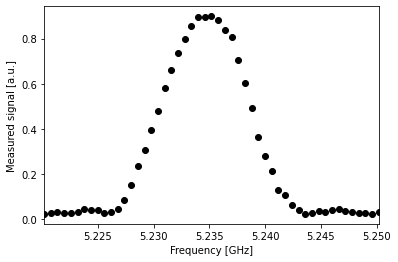

In [16]:
plt.scatter(frequencies_GHz, np.real(exp_vals), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

[[Model]]
    Model(lorentzian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 29
    # data points      = 51
    # variables        = 3
    chi-square         = 0.25506893
    reduced chi-square = 0.00531394
    Akaike info crit   = -264.200401
    Bayesian info crit = -258.404924
[[Variables]]
    amplitude:  0.01087751 +/- 3.8055e-04 (3.50%) (init = 0.01377356)
    center:     5.23468731 +/- 1.1975e-04 (0.00%) (init = 5.234591)
    sigma:      0.00348403 +/- 1.7270e-04 (4.96%) (init = 0.0042)
    fwhm:       0.00696805 +/- 3.4539e-04 (4.96%) == '2.0000000*sigma'
    height:     0.99379873 +/- 0.03428614 (3.45%) == '0.3183099*amplitude/max(1e-15, sigma)'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma) = 0.718


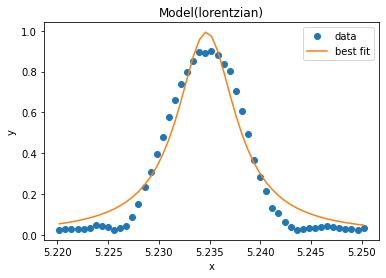

In [17]:
import lmfit

model = lmfit.models.LorentzianModel()
params = model.guess(np.array(exp_vals), x=np.array(frequencies_GHz))

result = model.fit(np.array(exp_vals), params, x=frequencies_GHz)
result.plot_fit()
print(result.fit_report())

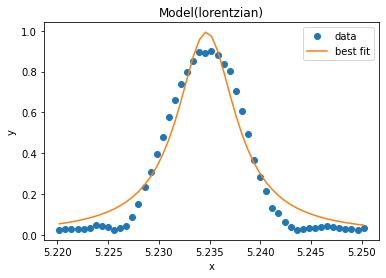

In [50]:
fig = result.plot_fit()
fig.get_figure().savefig("ibm_lagos_frequency_sweep_bestfit.png")

<class 'matplotlib.axes._subplots.AxesSubplot'>


In [19]:
qubit_frequency = result.params["center"].value
print(F"Our freq: {qubit_frequency} and reported: {freq01_estimate*1e-9}")

Our freq: 5.234687311789827 and reported: 5.2351912570204995


In [20]:
x_sched = inst_map.get("x", qubit)

In [21]:
drag_params = {}
drag_params["duration"] = x_sched.instructions[0][1].pulse.duration
drag_params["sigma"] = x_sched.instructions[0][1].pulse.sigma
drag_params["beta"] = x_sched.instructions[0][1].pulse.beta
drag_params["frequency"] = qubit_frequency*1.0e9

print(drag_params)

{'duration': 160, 'sigma': 40, 'beta': -0.1873817311710781, 'frequency': 5234687311.789827}


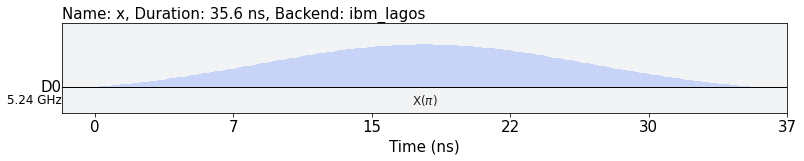

In [22]:
draw(x_sched, backend=backend)

In [23]:
amplitudes = np.linspace(-0.95, 0.95, 51)

In [24]:
amp_circs = amplitude_circuits(qubit, amplitudes, drag_params, backend)

In [25]:
transpiled_circs = transpile(amp_circs, backend, initial_layout=[0])

In [25]:
transpiled_circs[0].draw()

┌─────────────────────────┐ ░ ┌─┐
      q_0 -> 0 ┤ Amp(-0.950000000000000) ├─░─┤M├
               └─────────────────────────┘ ░ └╥┘
ancilla_0 -> 1 ───────────────────────────────╫─
                                              ║ 
ancilla_1 -> 2 ───────────────────────────────╫─
                                              ║ 
ancilla_2 -> 3 ───────────────────────────────╫─
                                              ║ 
ancilla_3 -> 4 ───────────────────────────────╫─
                                              ║ 
ancilla_4 -> 5 ───────────────────────────────╫─
                                              ║ 
ancilla_5 -> 6 ───────────────────────────────╫─
                                              ║ 
    measure: 1/═══════════════════════════════╩═
                                              0

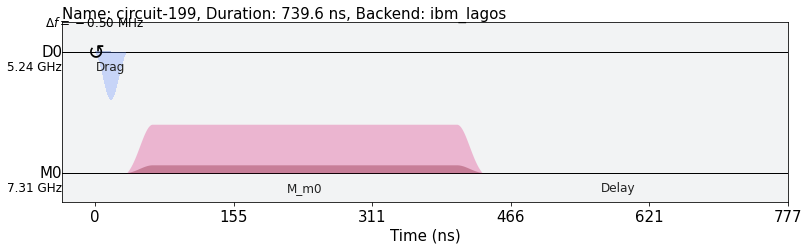

In [30]:
draw(schedule(transpiled_circs[50], backend), backend=backend)

In [27]:
# job = backend.run(transpiled_circs, job_name="amplitude", shots=2048)
job_id = job.job_id()
print(job.job_id())

61a67ba3a62b8250ceb513a5


In [26]:
# 11/23/2021
# lagos (12:34) 619c7a2768476d433a8a9304

# jakarta (12:45) 619c800853ac6c5c52d5a4c6

# 11/30/2021 
# lagos 61a67ba3a62b8250ceb513a5
results = backend.retrieve_job("61a67ba3a62b8250ceb513a5").result()

In [27]:
exp_vals = []
for counts in results.get_counts():
    exp_val = 0
    for k,v in counts.items():
        if k == "1":
            exp_val = v/sum(counts.values())
    exp_vals.append(exp_val)
print(exp_vals)

[0.7060546875, 0.857421875, 0.9599609375, 0.98681640625, 0.94775390625, 0.81884765625, 0.66552734375, 0.439453125, 0.27099609375, 0.12451171875, 0.0283203125, 0.01953125, 0.087890625, 0.23095703125, 0.43310546875, 0.62890625, 0.83935546875, 0.94189453125, 0.9833984375, 0.94091796875, 0.77978515625, 0.60302734375, 0.3876953125, 0.19580078125, 0.05029296875, 0.01416015625, 0.07275390625, 0.2109375, 0.4482421875, 0.662109375, 0.822265625, 0.95068359375, 0.9765625, 0.91943359375, 0.775390625, 0.556640625, 0.3779296875, 0.1904296875, 0.07373046875, 0.01611328125, 0.0517578125, 0.1455078125, 0.31689453125, 0.50537109375, 0.69775390625, 0.86328125, 0.95556640625, 0.98486328125, 0.91650390625, 0.81005859375, 0.6484375]


In [28]:
def baseline_remove(values):
    return np.array(values) - np.mean(values)

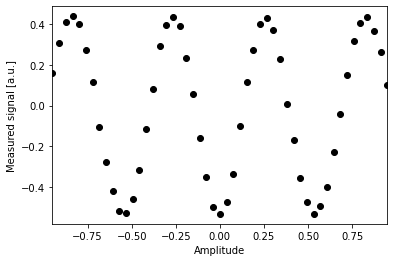

In [29]:
# baseline_remove(np.real(exp_vals))
plt.scatter(amplitudes, baseline_remove(np.real(exp_vals)), color='black') # plot real part of sweep values
plt.xlim([min(amplitudes), max(amplitudes)])
plt.xlabel("Amplitude")
plt.ylabel("Measured signal [a.u.]")
plt.show()

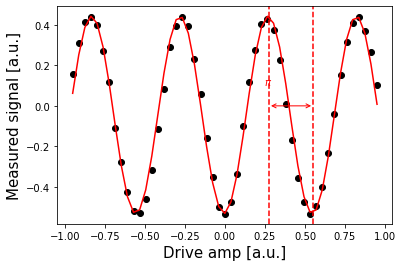

In [62]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit


fit_params, y_fit = fit_function(amplitudes,
                                 baseline_remove(np.real(exp_vals)), 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [0.8, 0.8, 0.5, 2])

plt.scatter(amplitudes, baseline_remove(np.real(exp_vals)), color='black')
plt.plot(amplitudes, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.savefig("ibm_lagos_amplitude_sweep_bestfit.png")
plt.show()

<Figure size 432x288 with 0 Axes>

In [31]:
print(fit_params)

[ 0.48667208 -0.04426078  0.55104551  3.08533401]


In [32]:
pi_amp = abs(drive_period / 2)
print(f"Our Pi amplitude = {pi_amp+0j} and reported: {x_sched.instructions[0][1].pulse.amp}")

Our Pi amplitude = (0.27552275427628076+0j) and reported: (0.26616942695600887+0j)


In [33]:
drag_params["amplitude"] = pi_amp+0j
print(drag_params)

{'duration': 160, 'sigma': 40, 'beta': -0.1873817311710781, 'frequency': 5234687311.789827, 'amplitude': (0.27552275427628076+0j)}


In [36]:
from qiskit.circuit.library import CXGate
from qiskit.circuit import Qubit, QuantumRegister
x_circs = x_gate_circuits(qubit, drag_params, backend)
qreg = QuantumRegister(1)
x_circs.add_register(qreg)

x_circs.append(CXGate(), [0,1])
x_circs.measure_active()
x_circs.draw()



┌──────────┐      ░ ┌─┐   
      q_0: ┤ Custom_x ├──■───░─┤M├───
           └──────────┘┌─┴─┐ ░ └╥┘┌─┐
   q408_0: ────────────┤ X ├─░──╫─┤M├
                       └───┘ ░  ║ └╥┘
measure: 2/═════════════════════╩══╩═
                                0  1

In [37]:
transpiled_test = transpile(x_circs, backend)
transpiled_test.draw()

┌──────────┐      ░ ┌─┐   
      q_0 -> 0 ┤ Custom_x ├──■───░─┤M├───
               └──────────┘┌─┴─┐ ░ └╥┘┌─┐
   q408_0 -> 1 ────────────┤ X ├─░──╫─┤M├
                           └───┘ ░  ║ └╥┘
ancilla_0 -> 2 ─────────────────────╫──╫─
                                    ║  ║ 
ancilla_1 -> 3 ─────────────────────╫──╫─
                                    ║  ║ 
ancilla_2 -> 4 ─────────────────────╫──╫─
                                    ║  ║ 
ancilla_3 -> 5 ─────────────────────╫──╫─
                                    ║  ║ 
ancilla_4 -> 6 ─────────────────────╫──╫─
                                    ║  ║ 
    measure: 2/═════════════════════╩══╩═
                                    0  1

In [41]:
job = backend.run(x_circs, job_name="simple_cnot", shots=2048)
job_id = job.job_id()
print(job.job_id())

61a6c6aed28a88365c8cfeaf


In [38]:
from qiskit.visualization import plot_histogram

#simple cnot experiment
# jakarta (1:33) 619c8acd53ac6c6f7dd5a511

# simple cnot 11/30/2021
# lagos 61a6c6aed28a88365c8cfeaf
results = backend.retrieve_job("61a6c6aed28a88365c8cfeaf").result()
# counts = results.get_counts()
# plot_histogram(counts)

In [39]:
print(results.get_counts())

{'00': 24, '01': 71, '10': 22, '11': 1931}


In [63]:
fig = plot_histogram(results.get_counts())

In [65]:
fig.savefig("customx_simple_cnot_experiment_results.png")

In [41]:
import qiskit.ignis.verification.tomography
from qiskit import QuantumRegister
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter

In [42]:
xc = x_gate_circuits(qubit, drag_params, backend)

custom_x_qpt_circs = process_tomography_circuits(xc, [0])

C:\Users\Zachary\anaconda3\envs\NewestPythonQiskit\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:465: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += preparation(prep_label[j], prep_qubits[j])
C:\Users\Zachary\anaconda3\envs\NewestPythonQiskit\lib\site-packages\qiskit\circuit\quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
C:\Users\Zachary\anaconda3\envs\NewestPythonQiskit\lib\site-packages\qiskit\ignis\verification\tomography\basis\circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is 

In [52]:
custom_x_qpt_circs[0].draw()

░ ┌──────────┐ ░ ┌───┐┌─┐
 q_0: ─░─┤ Custom_x ├─░─┤ H ├┤M├
       ░ └──────────┘ ░ └───┘└╥┘
c0: 1/════════════════════════╩═
                              0

In [53]:
custom_x_qpt_circs[1].draw()

░ ┌──────────┐ ░ ┌─────┐┌───┐┌─┐
 q_0: ─░─┤ Custom_x ├─░─┤ Sdg ├┤ H ├┤M├
       ░ └──────────┘ ░ └─────┘└───┘└╥┘
c0: 1/═══════════════════════════════╩═
                                     0

In [54]:
custom_x_qpt_circs[2].draw()

░ ┌──────────┐ ░ ┌─┐
 q_0: ─░─┤ Custom_x ├─░─┤M├
       ░ └──────────┘ ░ └╥┘
c0: 1/═══════════════════╩═
                         0

In [58]:
job = qiskit.execute(custom_x_qpt_circs, backend, shots=4000)
print(job.job_id())

61a70910313f811ba6c3b887


In [44]:
# IBM lagos
# 61a70910313f811ba6c3b887
qpt_job = backend.retrieve_job("61a70910313f811ba6c3b887")
qpt_tomo = ProcessTomographyFitter(qpt_job.result(), custom_x_qpt_circs)
qpt_tomo.data

{(('Zp',), ('X',)): {'0': 2062, '1': 1938},
 (('Zp',), ('Y',)): {'0': 2096, '1': 1904},
 (('Zp',), ('Z',)): {'0': 82, '1': 3918},
 (('Zm',), ('X',)): {'0': 1929, '1': 2071},
 (('Zm',), ('Y',)): {'0': 1536, '1': 2464},
 (('Zm',), ('Z',)): {'0': 3930, '1': 70},
 (('Xp',), ('X',)): {'0': 3921, '1': 79},
 (('Xp',), ('Y',)): {'0': 2133, '1': 1867},
 (('Xp',), ('Z',)): {'0': 2133, '1': 1867},
 (('Yp',), ('X',)): {'0': 1919, '1': 2081},
 (('Yp',), ('Y',)): {'0': 80, '1': 3920},
 (('Yp',), ('Z',)): {'0': 1689, '1': 2311}}

In [47]:
import time
# Tomographic reconstruction
t = time.time()
choi_fit_lstsq = qpt_tomo.fit(method='lstsq')

default_xc = QuantumCircuit(1)
default_xc.x(0)
target_unitary = qi.Operator(default_xc)

print('Fit time:', time.time() - t)
print('Average gate fidelity: F = {:.5f}'.format(qi.average_gate_fidelity(choi_fit_lstsq, target=target_unitary)))

Operator([[0.+0.j, 1.+0.j],
          [1.+0.j, 0.+0.j]],
         input_dims=(2,), output_dims=(2,))
Fit time: 0.006991147994995117
Average gate fidelity: F = 0.95421
